## Clean-ish TDA pipeline

**Input**
- input files are pkl file of recording data that has been processed using CEBRA_color_exchange.ipynb, cGratings_RRR.py, dGratings_RRR.py, or flash_RRR.py. 

- the pkl file should contain:
    - 'recordings': list of mice IDs recorded
    - 'datas': 2D matrix (time*trial, unit)


**Pipeline**
- load in spike data or embeddings
- generate embeddings (PCA->UMAP or CEBRA)
- embedding -> distance matrix (normal dist or KNN sparse (preferred for runtime & mem usage))
- persistent homology using Ripser & vietoris-rips filtration
- Fuzzy UMAP & barcodes from toroidal paper
    - Alpha complex filtration using GUDHI (& betti curves)

***must have Persim, Cython, and Ripser installed***

Author: @emilyekstrum
<br> 11/17/25

In [18]:
import cebra
import itertools
import os
import torch
import matplotlib
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from torch import cdist
#import seaborn as sns

from cebra import CEBRA
from cebra.data.helper import OrthogonalProcrustesAlignment
from glob import glob
from pathlib import Path
#from dlab.psth_and_raster import trial_by_trial
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from umap import UMAP
from ripser import ripser
import gudhi as gd
from gudhi import representations
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from persim import PersImage, PersistenceImager, plot_diagrams, bottleneck, bottleneck_matching, sliced_wasserstein, PersLandscapeExact
from persim.landscapes import plot_landscape_simple, plot_landscape

plt.style.use(['default', 'seaborn-v0_8-paper'])

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

c:\Users\denmanlab\.conda\envs\topology\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load in data from pkl file
- run script per neuron population of a stimuli

In [ ]:
def load_raw_data(filepath):
    """ Load raw data from a pickle file.
    
    Args:
        filepath (str): Path to the pickle file.
    Returns:
        recordings (list): List of recordings.
        datas (list): List of data arrays."""
    
    with open(filepath, "rb") as f:
        loaded = pkl.load(f)
    recordings = loaded["recordings"]
    datas      = loaded["datas"]

    return recordings, datas

## Load in finished embeddings from pkl file

In [ ]:
def load_embedding_data(filepath):
    """ Load embedding data from a pickle file.
    
    Args:
        filepath (str): Path to the pickle file.
    Returns:
        single_session_dict (dict): Dictionary of embeddings.
        session_names (list): List of session names."""
    
    with open(filepath, "rb") as f:
        single_session_dict = pkl.load(f)
        session_names = list(single_session_dict.keys())
        
    return single_session_dict, session_names

# Save embedding to pickle file

In [ ]:
def save_embedding_to_pkl(embedding_dict, filename):
    """ Save the embedding dictionary to a pickle file.

    Args:
        embedding_dict (dict): Dictionary of embeddings.
        filename (str): Path to save the pickle file."""
    
    with open(filename, 'wb') as f:
        pkl.dump(embedding_dict, f)
    print(f"Saved embeddings to {filename}")

## PCA -> UMAP 

In [ ]:
def pca_umap(recordings, datas, n_pca_components=10, n_umap_components=3, n_neighbors=600, min_dist=0.8, metric='cosine', save=True):
    """ PCA -> retain components for >=90% variance -> UMAP on components

    Args:
        recordings (list): List of recording names.
        datas (list): List of data arrays.
        n_pca_components (int): Number of PCA components to retain.
        n_umap_components (int): Number of UMAP components.
        n_neighbors (int): Number of neighbors for UMAP.
        min_dist (float): Minimum distance for UMAP.
        metric (str): Metric for UMAP.
        save (bool): Whether to save the embeddings.
    Returns:
        single_session_pca_umap (dict): Dictionary of UMAP models and embeddings.
        pca_umap_embeddings (dict): Dictionary of UMAP embeddings. """
    
    single_session_pca_umap = {}
    pca_umap_embeddings = {}

    for name, X in zip(recordings, datas):

        #zscore
        X_scaled = StandardScaler().fit_transform(X)

        #PCA - retain 90% variance
        pca_full = PCA(svd_solver='auto', random_state=42).fit(X_scaled)
        sum_var = np.cumsum(pca_full.explained_variance_ratio_)
        k = max(32, np.searchsorted(sum_var, 0.9)+1)
        k_safe = min(k, min(X_scaled.shape))  # Ensure k does not exceed min(n_samples, n_features)
        print(f"Using {k_safe} PCA components to retain 90% variance.")

        pca = PCA(n_components=k_safe, svd_solver='auto', random_state=42)
        X_pca = pca.fit_transform(X_scaled)

        print(f"Running UMAP on {name}")
        umap = UMAP(n_components=n_umap_components, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, n_jobs=-1)
        Z = umap.fit_transform(X_pca)

        pca_umap_embeddings[name] = Z
        single_session_pca_umap[name] = {'model' : umap, "embedding" : Z, "tensor" : X}

    if save == True:
        save_embedding_to_pkl(single_session_pca_umap, f'{filepath}{filename}.pkl')

    return single_session_pca_umap, pca_umap_embeddings




In [ ]:
def plot_3d_embedding(single_session_pca_umap):
    """ Plot 3D embedding

    Args:
        single_session_pca_umap (dict): Dictionary of UMAP embeddings."""

    n_cols = 4
    session_names = list(single_session_pca_umap.keys()) 
    n_sessions = len(session_names)
    n_rows = (n_sessions + n_cols -1) // n_cols

    fig= plt.figure(figsize=(4.5 * n_cols, 4.5 * n_rows))

    for i, name in enumerate(session_names):
        ax = fig.add_subplot(n_rows, n_cols, i+1, projection='3d')
        Z = single_session_pca_umap[name]['embedding']

        ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2], s=3, alpha = 0.3)
        ax.set_title(name, fontsize=16)
        ax.set_xlabel('Dim1'); ax.set_ylabel('Dim2'); ax.set_zlabel('Dim3')

    plt.suptitle('LGN PCA -> UMAP - Drifting Gratings', fontsize=20)
    plt.tight_layout()
    plt.show()

## CEBRA model training
- unsupervised

In [7]:
def CEBRA_model_train(recordings, datas, model_architecture='offset10-model', device='cuda', output_dimension=3, 
                      train_steps=30000, distance='cosine', filepath='/Users/emilyekstrum/Desktop/denmanLab/tda/actual_work/', filename ='LGNchromatic_gratings.pkl', save=True):
    """
    Train CEBRA model
    Using Juans code
    """
    single_session_CEBRA = dict()

    cebra_time_model = CEBRA(model_architecture = model_architecture,
                            batch_size         = 512,
                            learning_rate      = 3e-4,
                            #  temperature_mode   = "auto",
                            temperature        = 1,
                            #  min_temperature    = 1e-1,
                            output_dimension   = output_dimension,
                            max_iterations     = train_steps,
                            num_hidden_units   = 128,
                            distance           = distance,
                            conditional        = 'time', # time delta uses behavior/stimulus data to fit model
                            device             = device,
                            verbose            = True,
                            time_offsets       = 10,
                            optimizer          = 'adam',
                            )

    for name, X in zip(recordings, datas):
        print(name)
        out_path = Path(os.path.join(r'G:\cebra',name))
        out_path.mkdir(exist_ok=True)
        single_session_CEBRA[name] = {}

        cebra_time_model.fit(X.type(torch.FloatTensor))
        cebra_time = cebra_time_model.transform(X.type(torch.FloatTensor))

        cebra_time_model.save(os.path.join(out_path,f'{name}_lgn_time.pt'),backend='torch')

        single_session_CEBRA[name]['model']      = cebra_time_model
        single_session_CEBRA[name]['embedding']  = cebra_time

    if save == True:
        save_embedding_to_pkl(single_session_CEBRA, f'{filepath}{filename}.pkl')
    return single_session_CEBRA

In [ ]:
def plot_3d_CEBRA(filepath, ncols=4):
    """ Plot 3D CEBRA embeddings from a pickle file.

    Args:
        filepath (str): Path to the pickle file."""
    
    single_session, session_names = load_embedding_data(filepath, ncols=4)

    n=len(session_names)
    n_rows=int(np.ciel(n/ncols))

    fig = plt.figure(figsize=(20,4))

    for n, name in enumerate(session_names):
        embedding = single_session[name]['embedding']

        ax = plt.subplot2grid((2, 8), (0, n), projection='3d')
        ax.scatter(embedding[:,0], embedding[:,1], embedding[:,2], s=5, alpha=0.3,cmap='hsv', c=np.linspace(0,1,len(embedding)), 
                   clim=(0,1), rasterized=True)
        ax.set_title(name, y=0.8)
        
        ax = plt.subplot2grid((2, 8), (1, n), projection='3d')
        ax.scatter(embedding[:,0],
                embedding[:,1],
                embedding[:,2],
                s=5, alpha=0.3,
                cmap='hsv', c=np.linspace(0,1,len(embedding)), clim=(0,1), rasterized=True
                )

    for axs in fig.get_axes():
        axs.axis('off')
        axs.grid(False)
        axs.xaxis.pane.fill = False
        axs.yaxis.pane.fill = False
        axs.zaxis.pane.fill = False
        axs.xaxis.pane.set_edgecolor('w')
        axs.yaxis.pane.set_edgecolor('w')
        axs.zaxis.pane.set_edgecolor('w')

    plt.subplots_adjust(wspace=0,
                        hspace=0)
    plt.suptitle('LGN Time')
    plt.tight_layout()
    # plt.savefig(r'G:\cebra_v1_time.pdf',transparent=True)
    plt.show()
    

## Embedding -> matrix

In [ ]:
def embedding_to_matrix(embedding, metric='cosine', type='distance'):
    """ Convert embedding to distance matrix.
    Very computationally expensive. Consider using chunkec version
    
    Args:
        embedding (np.ndarray): Embedding array.
        metric (str): Metric for distance calculation.
        type (str): Type of matrix to compute ('distance' or 'correlation').
    Returns:
        matrix (np.ndarray): Distance or correlation matrix."""

    if type == 'distance':
        # Calculate the pairwise distances in the embedding
        distances_condensed = pdist(embedding, metric=metric)

        #Convert the condensed distance matrix to a square symmetric matrix
        matrix = squareform(distances_condensed)

    if type == 'correlation':
        # Calculate the correlation matrix
        matrix = np.corrcoef(embedding, rowvar=False) 
    
    print(f"Shape of the {type} matrix:", matrix.shape)

    return matrix

In [ ]:
def embedding_to_matrix_chunked(embedding, chunk_size=1000):
    """Calculate distance matrix in chunks to reduce memory usage - still not great
    
    Args:
        embedding (np.ndarray): Embedding array.
        chunk_size (int): Size of each chunk.
    Returns:
        matrix (np.ndarray): Distance matrix."""
    
    n = embedding.shape[0]
    matrix = np.zeros((n, n))
    
    for i in range(0, n, chunk_size):
        chunk = embedding[i:i+chunk_size]
        distances = cdist(chunk, embedding)
        matrix[i:i+chunk_size] = distances
        
    print(f"Shape of the distance matrix:", matrix.shape)
    return matrix

In [ ]:
# ok lets try to speed up distance calc with parallel processing

from scipy.spatial.distance import cdist 

def compute_chunk_distances(i, chunk, embedding, metric):
    """Helper function to compute distances for a single chunk
    
    Args:
        i (int): Starting index of the chunk.
        chunk (np.ndarray): Chunk of the embedding.
        embedding (np.ndarray): Full embedding array.
        metric (str): Metric for distance calculation.
    Returns:
        tuple: (starting index, distance matrix for the chunk)"""
    
    return i, cdist(chunk, embedding, metric=metric)

def embedding_to_matrix_chunked_paral(embedding, metric='cosine', chunk_size=1000, n_jobs=-1):
    """Calculate distance matrix in chunks using parallel processing
    
    Args:
        embedding (np.ndarray): Embedding array.
        metric (str): Metric for distance calculation.
        chunk_size (int): Size of each chunk.
        n_jobs (int): Number of parallel jobs.
    Returns:
        matrix (np.ndarray): Distance matrix."""
    
    # Convert to numpy array
    embedding = np.asarray(embedding)
    
    n = embedding.shape[0]
    matrix = np.zeros((n, n))
    
    # Generate chunks
    chunks = [(i, embedding[i:i+chunk_size]) 
             for i in range(0, n, chunk_size)]
    
    # Compute distances in parallel
    results = Parallel(n_jobs=n_jobs)(
        delayed(compute_chunk_distances)(i, chunk, embedding, metric)
        for i, chunk in chunks
    )
    
    # Combine results
    for i, distances in results:
        matrix[i:i+chunk_size] = distances
        
    print(f"Shape of the distance matrix:", matrix.shape)
    return matrix

In [ ]:
def knn_sparse_dist(embedding, n_neighbors=300, metric="euclidean", plot = False, plot_title= " "):
    """Makes symmetric sparse distance matrix
    
    Args:
        embedding (np.ndarray): Embedding array.
        n_neighbors (int): Number of neighbors for KNN.
        metric (str): Metric for distance calculation.
        plot (bool): Whether to plot the distance matrix.
        plot_title (str): Title for the plot.
        
    Returns: 
        sparse_matrix (csr_matrix): Symmetric sparse distance matrix."""
    
    nn = NearestNeighbors(n_neighbors=n_neighbors, metric=metric, n_jobs=-1)
    nn.fit(embedding)
    distances, indices = nn.kneighbors(embedding, return_distance=True)        
    num_samples = embedding.shape[0]
    rows = np.repeat(np.arange(num_samples), n_neighbors)
    cols = indices.ravel()
    vals = distances.ravel().astype(np.float32)

    sparse_matrix = csr_matrix((vals, (rows, cols)), shape=(num_samples, num_samples))
    # Symmetrize with min distance on shared edges
    sparse_matrix = sparse_matrix.minimum(sparse_matrix.transpose())

    if plot == True:
        m = min(600, sparse_matrix.shape[0])
        dense_sub = sparse_matrix[:m, :m]
        mask_sub = (dense_sub == 0)

        sns.heatmap(dense_sub, mask=mask_sub, cmap='viridis', square=True, cbar_kws ={'label' : 'Distance'})
        plt.title(plot_title)
        plt.show()
    return sparse_matrix


## Persistent homology using Ripser.py

In [ ]:
def tda_ripser(distance_matrix, name, stimuli, maxdim=2, thresh=0.5):
    """ Compute persistent homology using Ripser.py
     
      Args:
        distance_matrix (np.ndarray): Distance matrix.
        name (str): Name of the dataset.
        stimuli (str): Stimulus information.
        maxdim (int): Maximum homology dimension to compute.
        thresh (float): Threshold for distance matrix.
    Returns:
        dgms (list): List of persistence diagrams."""

    dgms = ripser(distance_matrix, distance_matrix=True, maxdim=maxdim)['dgms']
    #plot_diagrams(dgms, title=(f"Persistence Diagram of {name} - {stimuli}"), show=True)
    
    return dgms

## Fuzzy UMAP -> TDA 
- code from toroidal grid cell paper

In [ ]:
# RUNME from toroidal paper - helper functions 

from datetime import datetime 
import functools
import glob
from gudhi.clustering.tomato import Tomato
#import h5py
import matplotlib
from matplotlib import animation, cm, transforms, pyplot as plt, gridspec as grd
from matplotlib.collections import PathCollection
import numba
import numpy as np
from ripser import Rips, ripser
from scipy import stats, signal, optimize
from scipy.optimize import minimize
import scipy.io as sio
from scipy.ndimage import gaussian_filter,  gaussian_filter1d, rotate, binary_dilation, binary_closing
from scipy.stats import binned_statistic_2d, pearsonr, multivariate_normal
from scipy.special import factorial
from scipy.spatial.distance import cdist, pdist, squareform
import scipy.stats
from scipy.sparse import coo_matrix
from scipy.linalg import eigh
from scipy.sparse.linalg import lsmr
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score
import sys
import time
import os

def sample_denoising(data,  k = 10, num_sample = 500, omega = 0.2, metric = 'euclidean'):    
    n = data.shape[0]
    leftinds = np.arange(n)
    F_D = np.zeros(n)
    if metric in ("cosine", "correlation", "dice", "jaccard"):
        angular = True
    else:
        angular = False
    
    X = squareform(pdist(data, metric))
    knn_indices = np.argsort(X)[:, :k]
    knn_dists = X[np.arange(X.shape[0])[:, None], knn_indices].copy()

    sigmas, rhos = smooth_knn_dist(knn_dists, k, local_connectivity=0)
    rows, cols, vals = compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos)
    result = coo_matrix((vals, (rows, cols)), shape=(n, n))
    result.eliminate_zeros()
    transpose = result.transpose()
    prod_matrix = result.multiply(transpose)
    result = (result + transpose - prod_matrix)
    result.eliminate_zeros()
    X = result.toarray()
    F = np.sum(X,1)
    Fs = np.zeros(num_sample)
    Fs[0] = np.max(F)
    i = np.argmax(F)
    inds_all = np.arange(n)
    inds_left = inds_all>-1
    inds_left[i] = False
    inds = np.zeros(num_sample, dtype = int)
    inds[0] = i
    for j in np.arange(1,num_sample):
        F -= omega*X[i,:]
        Fmax = np.argmax(F[inds_left])
        Fs[j] = F[Fmax]
        i = inds_all[inds_left][Fmax]
        
        inds_left[i] = False   
        inds[j] = i
    d = np.zeros((num_sample, num_sample))
    
    for j,i in enumerate(inds):
        d[j,:] = X[i, inds]
    return inds, d, Fs

def smooth_knn_dist(distances, k, n_iter=64, local_connectivity=0.0, bandwidth=1.0):
    target = np.log2(k) * bandwidth
#    target = np.log(k) * bandwidth
#    target = k
    
    rho = np.zeros(distances.shape[0])
    result = np.zeros(distances.shape[0])

    mean_distances = np.mean(distances)

    for i in range(distances.shape[0]):
        lo = 0.0
        hi = np.inf
        mid = 1.0

        # TODO: This is very inefficient, but will do for now. FIXME
        ith_distances = distances[i]
        non_zero_dists = ith_distances[ith_distances > 0.0]
        if non_zero_dists.shape[0] >= local_connectivity:
            index = int(np.floor(local_connectivity))
            interpolation = local_connectivity - index
            if index > 0:
                rho[i] = non_zero_dists[index - 1]
                if interpolation > 1e-5:
                    rho[i] += interpolation * (
                        non_zero_dists[index] - non_zero_dists[index - 1]
                    )
            else:
                rho[i] = interpolation * non_zero_dists[0]
        elif non_zero_dists.shape[0] > 0:
            rho[i] = np.max(non_zero_dists)

        for n in range(n_iter):

            psum = 0.0
            for j in range(1, distances.shape[1]):
                d = distances[i, j] - rho[i]
                if d > 0:
                    psum += np.exp(-(d / mid))
#                    psum += d / mid
 
                else:
                    psum += 1.0
#                    psum += 0

            if np.fabs(psum - target) < 1e-5:
                break

            if psum > target:
                hi = mid
                mid = (lo + hi) / 2.0
            else:
                lo = mid
                if hi == np.inf:
                    mid *= 2
                else:
                    mid = (lo + hi) / 2.0
        result[i] = mid
        # TODO: This is very inefficient, but will do for now. FIXME
        if rho[i] > 0.0:
            mean_ith_distances = np.mean(ith_distances)
            if result[i] < 1e-3 * mean_ith_distances:
                result[i] = 1e-3 * mean_ith_distances
        else:
            if result[i] < 1e-3 * mean_distances:
                result[i] = 1e-3 * mean_distances

    return result, rho

@numba.njit(parallel=True, fastmath=True) 
def compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos):
    n_samples = knn_indices.shape[0]
    n_neighbors = knn_indices.shape[1]
    rows = np.zeros((n_samples * n_neighbors), dtype=np.int64)
    cols = np.zeros((n_samples * n_neighbors), dtype=np.int64)
    vals = np.zeros((n_samples * n_neighbors), dtype=np.float64)
    for i in range(n_samples):
        for j in range(n_neighbors):
            if knn_indices[i, j] == -1:
                continue  # We didn't get the full knn for i
            if knn_indices[i, j] == i:
                val = 0.0
            elif knn_dists[i, j] - rhos[i] <= 0.0:
                val = 1.0
            else:
                val = np.exp(-((knn_dists[i, j] - rhos[i]) / (sigmas[i])))
                #val = ((knn_dists[i, j] - rhos[i]) / (sigmas[i]))

            rows[i * n_neighbors + j] = i
            cols[i * n_neighbors + j] = knn_indices[i, j]
            vals[i * n_neighbors + j] = val

    return rows, cols, vals


def plot_barcode(persistence, file_name = ''):

    diagrams_roll = {}
    filenames=glob.glob('Results/Roll/' + file_name + '_H2_roll_*')
    for i, fname in enumerate(filenames): 
        f = np.load(fname, allow_pickle = True)
        diagrams_roll[i] = list(f['diagrams'])
        f.close() 

    cs = np.repeat([[0,0.55,0.2]],3).reshape(3,3).T
    alpha=1
    inf_delta=0.1
    legend=True
    colormap=cs
    maxdim = len(persistence)-1
    dims =np.arange(maxdim+1)
    num_rolls = len(diagrams_roll)

    if num_rolls>0:
        diagrams_all = np.copy(diagrams_roll[0])
        for i in np.arange(1,num_rolls):
            for d in dims:
                diagrams_all[d] = np.concatenate((diagrams_all[d], diagrams_roll[i][d]),0)
        infs = np.isinf(diagrams_all[0])
        diagrams_all[0][infs] = 0
        diagrams_all[0][infs] = np.max(diagrams_all[0])
        infs = np.isinf(diagrams_all[0])
        diagrams_all[0][infs] = 0
        diagrams_all[0][infs] = np.max(diagrams_all[0])


    min_birth, max_death = 0,0            
    for dim in dims:
        persistence_dim = persistence[dim][~np.isinf(persistence[dim][:,1]),:]
        min_birth = min(min_birth, np.min(persistence_dim))
        max_death = max(max_death, np.max(persistence_dim))
    delta = (max_death - min_birth) * inf_delta
    infinity = max_death + delta
    axis_start = min_birth - delta            
    plotind = (dims[-1]+1)*100 + 10 +1
    fig = plt.figure()
    gs = grd.GridSpec(len(dims),1)

    indsall =  0
    labels = ["$H_0$", "$H_1$", "$H_2$"] #, "$H_2$"]
    for dit, dim in enumerate(dims):
        axes = plt.subplot(gs[dim])
        axes.axis('off')
        d = np.copy(persistence[dim])
        d[np.isinf(d[:,1]),1] = infinity
        dlife = (d[:,1] - d[:,0])
        dinds = np.argsort(dlife)[-30:]
        dl1,dl2 = dlife[dinds[-2:]]
        if dim>0:
            dinds = dinds[np.flip(np.argsort(d[dinds,0]))]
        axes.barh(
            0.5+np.arange(len(dinds)),
            dlife[dinds],
            height=0.8,
            left=d[dinds,0],
            alpha=alpha,
            color=colormap[dim],
            linewidth=0,
        )
        indsall = len(dinds)
        if num_rolls>0:
            bins = 50
            cs = np.flip([[0.4,0.4,0.4], [0.6,0.6,0.6], [0.8, 0.8,0.8]])
            cs = np.repeat([[1,0.55,0.1]],3).reshape(3,3).T
            cc = 0
            lives1_all = diagrams_all[dim][:,1] - diagrams_all[dim][:,0]
            x1 = np.linspace(diagrams_all[dim][:,0].min()-1e-5, diagrams_all[dim][:,0].max()+1e-5, bins-2)
            
            dx1 = (x1[1] - x1[0])
            x1 = np.concatenate(([x1[0]-dx1], x1, [x1[-1]+dx1]))
            dx = x1[:-1] + dx1/2
            ytemp = np.zeros((bins-1))
            binned_birth = np.digitize(diagrams_all[dim][:,0], x1)-1
            x1  = d[dinds,0]
            ytemp =x1 + np.max(lives1_all)
            axes.fill_betweenx(0.5+np.arange(len(dinds)), x1, ytemp, color = cs[(dim)], zorder = -2, alpha = 0.3)

        axes.plot([0,0], [0, indsall], c = 'k', linestyle = '-', lw = 1)
        axes.plot([0,indsall],[0,0], c = 'k', linestyle = '-', lw = 1)
        axes.set_xlim([0, infinity])




In [ ]:
# these params are from toroidal paper - likely will want to change them so it doesn't crash the kernel and runs faster

def fuzzy_umap(recordings, datas, nbs = 800, n_points = 1200, metric = 'cosine', 
               maxdim = 2, active_times=15000, k = 1000, num_times=5,
               sigma=1500,save=True):

    """ Fuzzy UMAP + TDA pipeline
    Args:
        recordings (list): List of recording names.
        datas (list): List of data arrays.
        nbs (int): Number of neighbors for KNN. (heavily influences run time and memory usage)
        n_points (int): Number of points for denoising.
        metric (str): Metric for distance calculation.
        ph_classes (list): List of homology dimensions to compute.
        maxdim (int): Maximum homology dimension to compute.
        active_times (int): Number of active times.
        k (int): Number of neighbors for denoising.
        num_times (int): Number of times for denoising.
        sigma (int): Sigma for denoising."""
    
    coeff = 2 # field coeff, important for orientation data but not here

    for name, X in zip(recordings, datas):
        X_scaled = StandardScaler().fit_transform(X)

        # optimize k for least dims that explain 90% variance but at least 32, and not more than min(n_samples, n_features)
        pca_full = PCA(svd_solver='auto', random_state=42).fit(X_scaled)
        sum_var = np.cumsum(pca_full.explained_variance_ratio_)
        k = max(32, np.searchsorted(sum_var, 0.9)+1)
        k = min(k, min(X_scaled.shape))  # Ensure k does not exceed min(n_samples, n_features)

        pca = PCA(n_components=k, svd_solver='auto', random_state=42)
        X_pca = pca.fit_transform(X_scaled)
        print("PCA done")
        #my code end

        #dim_red_spikes_move_scaled,__,__ = pca(preprocessing.scale(sspikes[movetimes,:]), dim = dim)
        indstemp,dd,fs  = sample_denoising(X_pca,  k, 
                                            n_points, 1, metric)
        dim_red_spikes_move_scaled = X_pca[indstemp,:]
        X = squareform(pdist(X_pca, metric))
        print("Denoising done")

        # Constructing the fuzzy simplicial set with KNN
        knn_indices = np.argsort(X)[:, :nbs]
        knn_dists = X[np.arange(X.shape[0])[:, None], knn_indices].copy()
        sigmas, rhos = smooth_knn_dist(knn_dists, nbs, local_connectivity=0)
        print("KNN done")

        # Compute the membership strengths of KNN
        rows, cols, vals = compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos)
        print("Membership strengths done")
        result = coo_matrix((vals, (rows, cols)), shape=(X.shape[0], X.shape[0])) #change to csr for speed?
        result.eliminate_zeros()
        transpose = result.transpose()
        prod_matrix = result.multiply(transpose)
        result = (result + transpose - prod_matrix)
        result.eliminate_zeros()
        d = result.toarray()

        # negative log transform
        d = -np.log(d)
        print("Negative log transform done")

        # distance matrix
        np.fill_diagonal(d,0)
        print("Distance matrix done")

        # TDA
        # makes a plot with each row of the graphs as a homology group
        persistence = ripser(d, maxdim=maxdim, coeff=coeff, do_cocycles= True, distance_matrix = True)
        print("Ripser done")  

        print(f"Plotting barcode for {name}")
        plot_barcode(persistence['dgms'], show =True)
        plt.title(f'Barcode for {name}')
        plt.show()

        print(f"Plotting persistence diagram for {name}")
        plot_diagrams(persistence['dgms'], show =True)

## GUDHI Betti Curves - alpha vs vietoris rips complex

- questionable if this works - user beware

In [ ]:
import os, gc
import numpy as np
import matplotlib.pyplot as plt
import gudhi
import pickle as pkl
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

def load_embedding_data(filepath):
    """ Load embedding data from a pickle file.
    Args:
        filepath (str): Path to the pickle file.
    Returns:
        single_session_dict (dict): Dictionary of embeddings.
        session_names (list): List of session names."""

    with open(filepath, "rb") as f:
        single_session_dict = pkl.load(f)
    session_names = list(single_session_dict.keys())
    return single_session_dict, session_names

def list_sessions(filepath):
    """ List available sessions in the embedding pickle file.
    Args:
        filepath (str): Path to the pickle file.
    Returns:
        names (list): List of session names."""
    
    _, names = load_embedding_data(filepath)
    print("Available sessions:", names)
    return names

def downsample_embedding(embed, n_target=1000, method="fps", seed=42):
    """ Downsample embedding to n_target points using specified method.

    Args:
        embed (np.ndarray): Embedding array.
        n_target (int): Target number of points.
        method (str): Downsampling method ('random' or 'fps').
    Returns:
        downsampled_embed (np.ndarray): Downsampled embedding array."""
    
    N = embed.shape[0]
    if n_target >= N:
        return embed  # nothing to downsample
    
    rng = np.random.default_rng(seed)

    if method == "random":
        # randomly downsample
        idx = rng.choice(N, size=n_target, replace=False)
        return embed[idx]

    elif method == "fps":
        # Farthest Point Sampling 
        idxs = [rng.integers(N)]
        dists = np.linalg.norm(embed - embed[idxs[0]], axis=1)

        for _ in range(1, n_target):
            next_idx = np.argmax(dists)
            idxs.append(next_idx)
            new_dists = np.linalg.norm(embed - embed[next_idx], axis=1)
            dists = np.minimum(dists, new_dists)

        return embed[idxs]

    else:
        raise ValueError("method must be 'random' or 'fps'")


def _betti_curve_from_intervals(intervals, radii):
    """ Fasterish? Betti curve from persistence intervals for a single homology dim.

    Args:
        intervals (np.ndarray): Persistence intervals (birth, death).
        radii (np.ndarray): Radii at which to evaluate Betti curve.
    Returns:
        betti_curve (np.ndarray): Betti numbers at each radius."""
    
    if len(intervals) == 0:
        return np.zeros_like(radii, dtype=int)
    I = np.asarray(intervals)
    births = np.sort(I[:, 0])
    finite_deaths = np.sort(I[np.isfinite(I[:, 1]), 1])
    births_le = np.searchsorted(births, radii, side="right")
    deaths_le = np.searchsorted(finite_deaths, radii, side="right")
    print("Betti curves calculated")
    return (births_le - deaths_le).astype(int)

def compute_betti_curves_alpha(embed, maxdim=2, radii=None, n_radii=60):
    """ Compute Betti curves using Alpha Complex.
    Args:
        embed (np.ndarray): Point cloud embedding data.
        maxdim (int): Maximum homology dimension to compute.
        radii (np.ndarray or None): Radii at which to evaluate Betti curves. If None, auto-generate.
        n_radii (int): Number of radii to generate if radii is None.
    Returns:
        curves (dict): Dictionary {dim: (radii, betti_curve)} for dims 0 to maxdim."""

    embed = np.asarray(embed, dtype=np.float32)
    alpha_complex = gudhi.AlphaComplex(points=embed)
    sim_tree = alpha_complex.create_simplex_tree()
    sim_tree.compute_persistence()

    intervals_by_dim = {dim: np.array(sim_tree.persistence_intervals_in_dimension(dim))
    for dim in range(maxdim+1)}

    # Auto grid
    if radii is None:
        births_all, deaths_all = [], []
        for i in intervals_by_dim.values():
            if i.size:
                births_all.append(i[:, 0])
                finite = i[np.isfinite(i[:, 1])]
                if finite.size:
                    deaths_all.append(finite[:, 1])
        if births_all:
            bmin = min(map(np.min, births_all))
            dmax = max(map(np.max, deaths_all)) if deaths_all else (max(map(np.max, births_all)) + 1.0)
            if not np.isfinite(dmax) or dmax <= bmin:
                dmax = bmin + 1.0
            radii = np.linspace(bmin, dmax, n_radii)
        else:
            radii = np.linspace(0.0, 1.0, n_radii)

    curves = {dim: (radii, _betti_curve_from_intervals(i, radii))
    for dim, i in intervals_by_dim.items()}
    print("Betti curves using alpha complex done")
    return curves

# TODO: finish this
# def compute_betti_curves_VR(X, maxdim=2): 
#     curves = {d: (radii, _betti_curve_from_intervals(I, radii))}
#     for _ in len(maxdim -1):
#         dgms = ripser(X, distance_matrix=True, maxdim=maxdim)['dgms']

#     curves =
#     print("Betti cuves using vietoris-rips complex done")
#     return curves

def plot_betti_curves(curves, title=None):
    """ Plot Betti curves dict {dim: (radii, beta)} for dims 0-k

    Args:
        curves (dict): Dictionary of Betti curves.
        title (str or None): Plot title."""

    print("Plotting betti curves")
    colors = {0: "tab:blue", 1: "tab:orange", 2: "tab:green", 3: "tab:red"}
    linestyles = {0: "-", 1: "--", 2: "-.", 3: ":"}

    plt.figure(figsize=(6.5, 4.0))
    for d, (r, beta) in sorted(curves.items()):
        plt.plot(r, beta, label=f"H{d}", color=colors.get(d, None), linestyle=linestyles.get(d, "-"))
    plt.xlabel("Radius")
    plt.ylabel("Betti number")
    plt.title(title or "Betti Curves")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()


def betti_curves_for_session(filepath, session_name, maxdim=2, n_target=1000, n_radii=60, seed=42):
    """ Load a single embedding file, pick one session, downsample, Alpha-complex Betti curves, and plot.

    Args:
        filepath (str): Path to the pickle file.
        session_name (str): Session name to process.
        maxdim (int): Maximum homology dimension to compute.
        n_target (int): Target number of points for downsampling.
        n_radii (int): Number of radii for Betti curves. """
    
    sess_dict, sess_names = load_embedding_data(filepath)
    if session_name not in sess_names:
        raise KeyError(f"session_name '{session_name}' not found. Available: {sess_names}")

    emb = np.asarray(sess_dict[session_name]["embedding"], dtype=np.float32)
    emb_ds = knn_sparse_dist(emb, n_neighbors= 300, metric = 'cosine', plot = False)
    #emb_ds = downsample_embedding(emb, n_target=n_target, method="fps", seed=seed)

    curves = compute_betti_curves_alpha(emb_ds, maxdim=maxdim, radii=None, n_radii=n_radii)
    plot_betti_curves(curves, title=f"{os.path.basename(filepath)} — {session_name} (N={emb_ds.shape[0]})")

    # cleanup
    del emb, emb_ds, curves
    gc.collect()


if __name__ == "__main__":
    embedding_path = (r"C:\Users\denmanlab\Desktop\Emily_rotation\3d_embed\V1_3D_CEBRA_unsup_time_chromatic_gratings.pkl")
    # list_sessions(embedding path)
    session = "C161"

betti_curves_for_session(embedding_path, session, maxdim=2, n_target=1000, n_radii=32,seed=42)

UnboundLocalError: cannot access local variable 'emb_ds' where it is not associated with a value

## Workflow

In [17]:
# load in raw data from pkl file
recordings, datas = load_raw_data(r"C:\Users\denmanlab\Desktop\Emily_rotation\data_to_run_at_home\LGNcolor_exchange.pkl")


In [ ]:
# load in pca->umap embeddings
session_dict, names = load_embedding_data("path")

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (1908411899.py, line 2)

In [ ]:


# PCA -> UMAP
single_session_pca_umap, pca_umap_embeddings = pca_umap(recordings, datas, n_pca_components=10, n_umap_components=3, n_neighbors=600, min_dist=0.8, metric='cosine', save=False)
#save_embedding_to_pkl(single_session_pca_umap, f'/Users/emilyekstrum/Desktop/denmanLab/tda/actual_work/pca_umap_lgn_gratings.pkl')
#plot_3d_embedding(single_session_pca_umap)


In [ ]:


# CEBRA
single_session_CEBRA = CEBRA_model_train(recordings, datas, model_architecture='offset10-model', device='cuda', output_dimension=3, 
                     train_steps=30000, distance='cosine', filepath='/Users/emilyekstrum/Desktop/denmanLab/tda/actual_work/', filename='cebra_lgn_gratings', save=False)
#save_embedding_to_pkl(single_session_CEBRA, f'/Users/emilyekstrum/Desktop/denmanLab/tda/actual_work/cebra_lgn_gratings.pkl')
#plot_3d_CEBRA()


In [47]:
persistence_diagrams = {}

In [48]:
# Persistence diagrams

single_session = pd.read_pickle(r"C:\Users\denmanlab\Desktop\Emily_rotation\3d_embed\LGN_3d_pca_umap_single_session_color_exchange.pkl")
good_recordings = ['C159']


for n, name in enumerate(good_recordings):
    embedding = single_session[name]['embedding']
    sparse_matrix = knn_sparse_dist(embedding, n_neighbors=300, metric='cosine', plot = True, plot_title = " ")
    #print(f"{name}")
    #dgms = tda_ripser(sparse_matrix, name, "LGN - Color Exchange - 32D \n PCA->UMAP", maxdim=1)
    #persistence_diagrams[name] = dgms

C159


In [ ]:
# print shapes of persistence diagrams from Ripser

for key,val in persistence_diagrams.items():
    for i,dgm in enumerate(val):
        print(f'{key} | H{i} | shape: {dgm.shape}')

C159 | H0 | shape: (33036, 2)
C159 | H1 | shape: (10311, 2)


In [43]:
save_embedding_to_pkl(persistence_diagrams, r"C:\Users\denmanlab\Desktop\Emily_rotation\persistence_profiles.pkl")

Saved embeddings to C:\Users\denmanlab\Desktop\Emily_rotation\persistence_profiles.pkl


In [7]:
test_persis_diags = persistence_diagrams

In [14]:
print(len(test_persis_diags['C153'][0]))
print(len(test_persis_diags['C159'][0]))


# bottleneck distance - to compare persistence diagrams - takes too long! boring
#distance_bottleneck = bottleneck(test_persis_diags['C159'][0], test_persis_diags['C153'][0])

# sliced wasserstein distance - alledgedly faster
#sw = sliced_wasserstein(test_persis_diags['C153'][0], test_persis_diags['C159'][0])

33982
33872


In [20]:
for key, val in test_persis_diags.items():
    for i, dgm in enumerate(val):
        print(f"{key} | H{i} | shape: {dgm.shape}")

C153 | H0 | shape: (33982, 2)
C153 | H1 | shape: (9717, 2)
C159 | H0 | shape: (33872, 2)
C159 | H1 | shape: (10063, 2)


In [24]:
# embedding to distance matrix
matrix = embedding_to_matrix_chunked_paral(session_dict[names[0]]['embedding'], metric='cosine', chunk_size=1000, n_jobs=-1)


: 

In [ ]:
# Build sparse distances from embedding
embedding = session_dict[names[0]]['embedding']
sparse_matrix = knn_sparse_dist(embedding, k=300, metric="euclidean")     # or "cosine"

In [ ]:

# Ripser.py TDA
tda_ripser(sparse_matrix)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(


KeyboardInterrupt: 

In [22]:
# fuzzy UMAP -> TDA 
fuzzy_umap(recordings, datas, nbs = 64, n_points = 800, metric = 'cosine', 
               ph_classes=[0,1], maxdim = 1, active_times=15000, k = 1000, num_times=3,
               sigma=1500,save=True)

PCA done


IndexError: index 0 is out of bounds for axis 0 with size 0

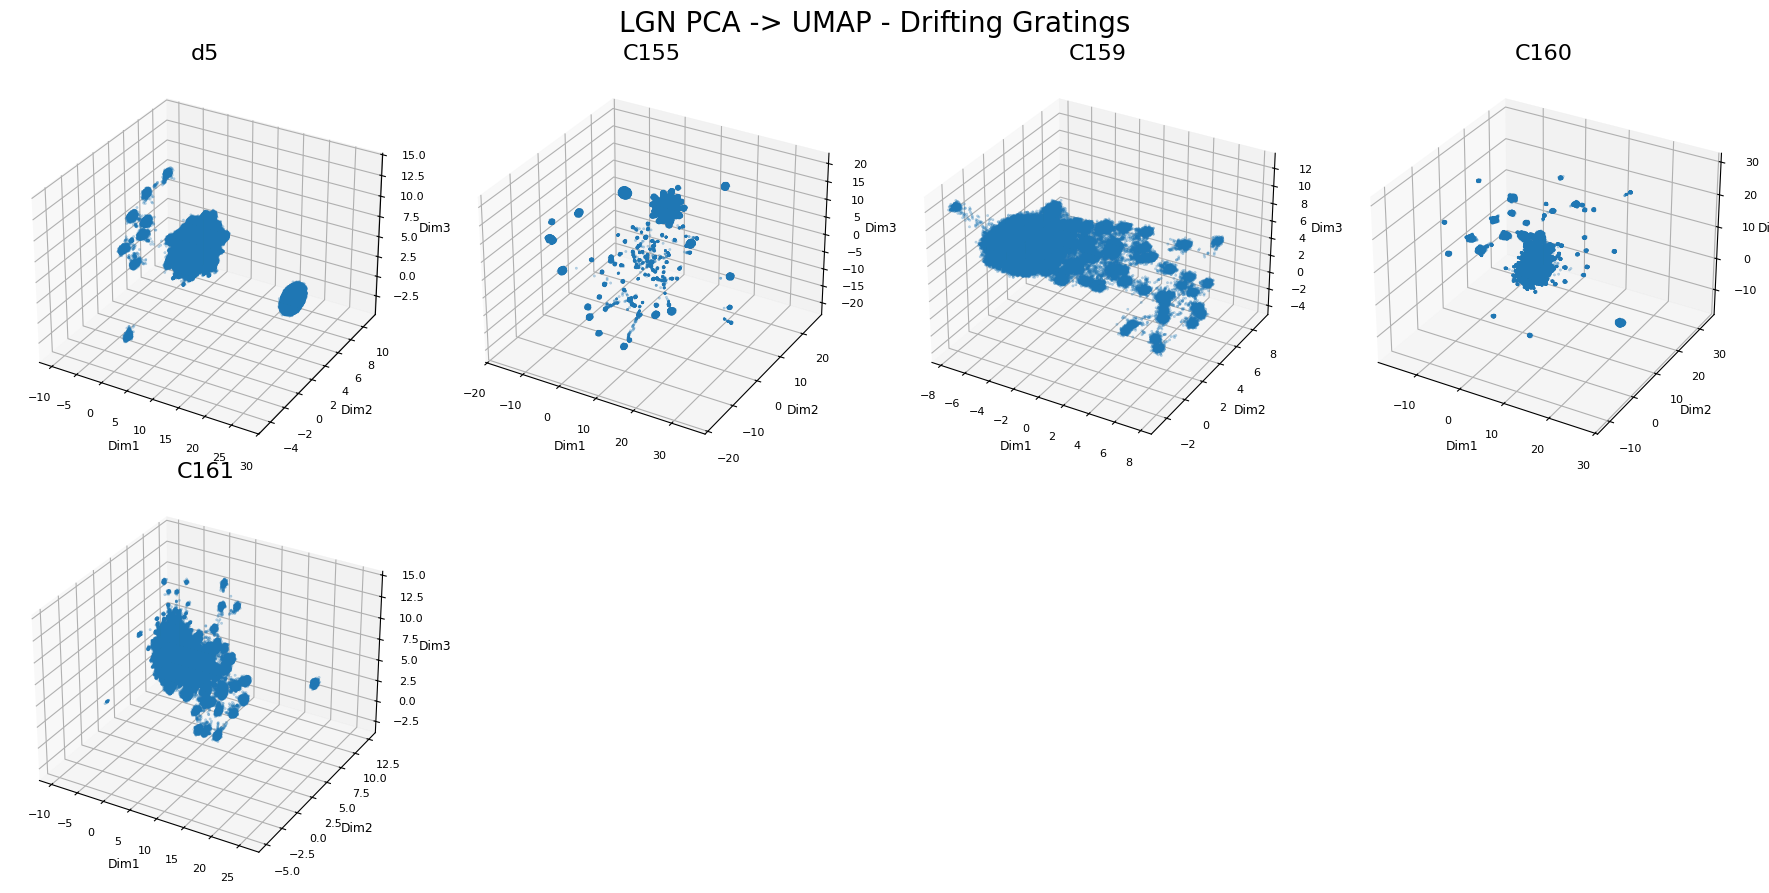

KeyboardInterrupt: 

In [ ]:
# visualize embeddings

#3d
import os
filepath="/Users/emilyekstrum/Desktop/denmanLab/tda/actual_work/3d" # path to directory with pkl files containing embeddings
for filename in os.listdir(filepath):
    full_path = os.path.join(filepath, filename)
    if filename.lower().endswith('pkl'):
        with open(full_path, "rb") as f:
            sessions_dict = pkl.load(f)

            n_cols = 4
            session_names = list(sessions_dict.keys()) 
            n_sessions = len(session_names)
            n_rows = (n_sessions + n_cols - 1) // n_cols

            fig = plt.figure(figsize=(4.5 * n_cols, 4.5 * n_rows))

            for i, name in enumerate(session_names):
                ax = fig.add_subplot(n_rows, n_cols, i + 1, projection='3d')
                Z = sessions_dict[name]['embedding']

                ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2], s=3, alpha=0.3)
                ax.set_title(name, fontsize=16)
                ax.set_xlabel('Dim1')
                ax.set_ylabel('Dim2')
                ax.set_zlabel('Dim3')

            plt.suptitle('LGN PCA -> UMAP - Drifting Gratings', fontsize=20)
            plt.tight_layout()
            plt.show()


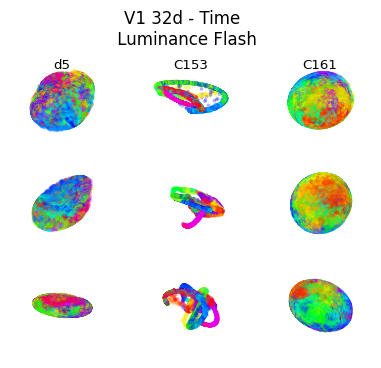

In [ ]:
# plot CEBRA embeddings

single_session = pd.read_pickle(r"C:\Users\denmanlab\Desktop\Emily_rotation\32d_embed\LGN_32d_CEBRA_unsup_time_color_exchange.pkl")
recordings = ['d5', 'C153', 'C161']

fig = plt.figure(figsize=(5,4))

for n, name in enumerate(recordings):
    embedding = single_session[name]['embedding']
    # label     = single_session[name]['labels']

    ax = plt.subplot2grid((3, len(recordings)), (0, n), projection='3d')
    ax.scatter(embedding[:,0],
               embedding[:,1],
               embedding[:,2],
               s=5, alpha=0.3,
               cmap='hsv', c=np.linspace(0,1,len(embedding)), clim=(0,1), rasterized=True
               )
    ax.set_title(name, y=0.8)

    ax = plt.subplot2grid((3, len(recordings)), (1, n), projection='3d')
    ax.scatter(embedding[:,13],
               embedding[:,14],
               embedding[:,15],
               s=5, alpha=0.2,
               cmap='hsv', c=np.linspace(0,1,len(embedding)), clim=(0,1), rasterized=True
               ) 
    
    ax = plt.subplot2grid((3, len(recordings)), (2, n), projection='3d')
    ax.scatter(embedding[:,29],
               embedding[:,30],
               embedding[:,31],
               s=5, alpha=0.2,
               cmap='hsv', c=np.linspace(0,1,len(embedding)), clim=(0,1), rasterized=True
               ) 

for axs in fig.get_axes():
    axs.axis('off')
    axs.grid(False)
    axs.xaxis.pane.fill = False
    axs.yaxis.pane.fill = False
    axs.zaxis.pane.fill = False
    axs.xaxis.pane.set_edgecolor('w')
    axs.yaxis.pane.set_edgecolor('w')
    axs.zaxis.pane.set_edgecolor('w')

plt.subplots_adjust(wspace=0,
                    hspace=0)
plt.suptitle('V1 32d - Time \n Luminance Flash')
# plt.savefig(r'G:\cebra_v1_time.pdf',transparent=True)
plt.show()